In [1]:
import IPython
import numpy as np
import matplotlib.pyplot as plt
import librosa
import sys ; sys.path.append('../')
from tqdm import tqdm
import soundfile as sf

In [2]:
import glob
import srmrpy as srmr
import mir_eval
import pystoi
def get_audio_list(path, file_types = ('.npy')):
    search_path = path + '/**/*'
    audio_list = []
    for file_type in file_types:
        audio_list.extend(glob.glob(search_path+file_type, recursive=True))
    return audio_list

In [3]:
clean_list = get_audio_list('/home/martin/deep-dereverb/data/test/clean/')
reverb_list = get_audio_list('/home/martin/deep-dereverb/data/test/real/')
clean_list.sort(); reverb_list.sort()
reverb = np.load(reverb_list[0])
clean = np.load(clean_list[0]) 

In [4]:
stft_reverb = librosa.stft(reverb, n_fft=512, hop_length=128)#[:-1,:]# Descarto altas frecuencias
mag_reverb = np.abs(stft_reverb)
pha_reverb = np.angle(stft_reverb)

stft_clean = librosa.stft(clean, n_fft=512, hop_length=128)#[:-1,:]# Descarto altas frecuencias
mag_clean = np.abs(stft_clean)
pha_clean = np.angle(stft_clean)

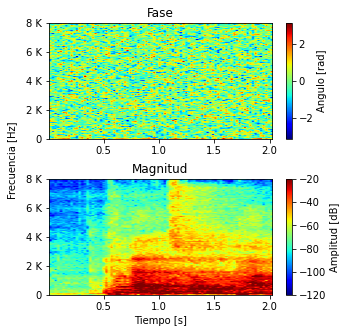

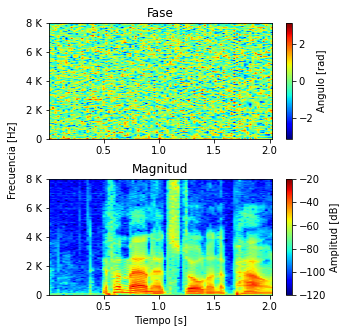

In [5]:
fig = plt.figure(1, figsize=(5,5))
plt.subplot(2,1,1)
plt.title('Fase')
plt.yticks([0, 2000, 4000, 6000, 8000], ['0', '2 K', '4 K', '6 K', '8 K'])
plt.specgram(reverb, Fs=16000, NFFT=512, noverlap=128, mode='angle', cmap='jet')
cbar = plt.colorbar()
cbar.set_label('Angulo [rad]')

plt.subplot(2,1,2)
plt.title('Magnitud')
plt.specgram(reverb, Fs=16000, NFFT=512, noverlap=128, mode='magnitude', cmap='jet', vmax=-20, vmin=-120)
cbar = plt.colorbar()
plt.xlabel('Tiempo [s]')
plt.yticks([0, 2000, 4000, 6000, 8000], ['0', '2 K', '4 K', '6 K', '8 K'])
fig.text(0.01, 0.5, 'Frecuencia [Hz]', va='center', rotation='vertical')
cbar.set_label('Amplitud [dB]')
plt.subplots_adjust(hspace=0.35)
plt.savefig('imagenes/fase_reverb', bbox_inches='tight')

fig = plt.figure(2, figsize=(5,5))
plt.subplot(2,1,1)
plt.title('Fase')
plt.yticks([0, 2000, 4000, 6000, 8000], ['0', '2 K', '4 K', '6 K', '8 K'])
plt.specgram(clean, Fs=16000, NFFT=512, noverlap=128, mode='angle', cmap='jet')
cbar = plt.colorbar()
cbar.set_label('Angulo [rad]')

plt.subplot(2,1,2)
plt.title('Magnitud')
plt.specgram(clean, Fs=16000, NFFT=512, noverlap=128, mode='magnitude', cmap='jet', vmax=-20, vmin=-120)
cbar = plt.colorbar()
plt.xlabel('Tiempo [s]')
plt.yticks([0, 2000, 4000, 6000, 8000], ['0', '2 K', '4 K', '6 K', '8 K'])
fig.text(0.01, 0.5, 'Frecuencia [Hz]', va='center', rotation='vertical')
cbar.set_label('Amplitud [dB]')
plt.subplots_adjust(hspace=0.35)
plt.savefig('imagenes/fase_clean', bbox_inches='tight')

In [6]:
def get_specs(clean_path, reverb_path):
    reverb = np.load(reverb_path)
    clean = np.load(clean_path) 
    stft_reverb = librosa.stft(reverb, n_fft=512, hop_length=128)#[:-1,:]# Descarto altas frecuencias
    mag_reverb = np.abs(stft_reverb)
    pha_reverb = np.angle(stft_reverb)

    stft_clean = librosa.stft(clean, n_fft=512, hop_length=128)#[:-1,:]# Descarto altas frecuencias
    mag_clean = np.abs(stft_clean)
    pha_clean = np.angle(stft_clean)
    return mag_clean, pha_reverb, clean

def rec_fasereverb(mag_clean, pha_reverb):
    stft_build = mag_clean * np.exp(1j*pha_reverb)
    recover = librosa.istft(stft_build, hop_length=128, win_length=512)
    return recover

def rec_grifininit(mag_clean, pha_reverb, it=100):
    #stft_build = mag_clean * np.exp(1j*pha_reverb)
    stft_build = mag_clean
    recover = librosa.griffinlim(stft_build, n_iter=it, hop_length=128, win_length=512, init=None)
    return recover


def rec_griffin(mag_clean, pha_reverb, it=100):
    recover = librosa.griffinlim(mag_clean, n_iter=it, hop_length=128, win_length=512, init='random')
    return recover

def get_metricas(clean, reverb, fs):
    SRMR = srmr.srmr(reverb, fs)[0]
    SDR, _, _, _ = mir_eval.separation.bss_eval_sources(clean, reverb, compute_permutation=True)
    ESTOI = pystoi.stoi(clean, reverb, fs, extended = True)
    return SRMR, SDR[0], ESTOI

In [7]:
clean_list = get_audio_list('/home/martin/deep-dereverb/data/test/clean/')
reverb_list = get_audio_list('/home/martin/deep-dereverb/data/test/real/')
clean_list.sort(); reverb_list.sort()

In [8]:
import IPython
params_1 = []
params_2 = []
params_3 = []
for clean_path, reverb_path in tqdm(zip(clean_list, reverb_list[:100])):
    mag_clean, pha_reverb, audio_clean = get_specs(clean_path, reverb_path)
    recover_1 = rec_fasereverb(mag_clean, pha_reverb)
    recover_2 = rec_grifininit(mag_clean, pha_reverb, it=100)
    recover_3 = rec_griffin(mag_clean, pha_reverb, it=100)
    params_1.append([get_metricas(audio_clean, recover_1, 16000)])
    params_2.append([get_metricas(audio_clean, recover_2, 16000)])
    params_3.append([get_metricas(audio_clean, recover_3, 16000)])    
    #IPython.display.display(IPython.display.Audio(audio_clean, rate=16000))
    #IPython.display.display(IPython.display.Audio(recover_1, rate=16000))
    #IPython.display.display(IPython.display.Audio(recover_2, rate=16000))
    #IPython.display.display(IPython.display.Audio(recover_3, rate=16000))
    #sf.write('audios/recover_phasereverb.wav', recover_1, 16000)
    #sf.write('audios/recover_griffin-init.wav', recover_2 ,16000)
    #sf.write('audios/recover_griffin.wav', recover_3, 16000)
    #import pdb; pdb.set_trace()

100it [01:44,  1.04s/it]


In [12]:
srmr_, sdr_, estoi_ = [], [], []
for param in params_1:
    srmr_.append(param[0][0])
    sdr_.append(param[0][1])
    estoi_.append(param[0][2])
print('SRMR: {:.2f}, SDR: {:.2f}, ESTOI: {:.2f}'.format(np.median(srmr_), np.median(sdr_), np.median(estoi_)))

SRMR: 4.23, SDR: 2.11, ESTOI: 0.89


In [13]:
srmr_, sdr_, estoi_ = [], [], []
for param in params_2:
    srmr_.append(param[0][0])
    sdr_.append(param[0][1])
    estoi_.append(param[0][2])
print('SRMR: {:.2f}, SDR: {:.2f}, ESTOI: {:.2f}'.format(np.median(srmr_), np.median(sdr_), np.median(estoi_)))

SRMR: 3.73, SDR: -2.09, ESTOI: 0.99


In [14]:
srmr_, sdr_, estoi_ = [], [], []
for param in params_3:
    srmr_.append(param[0][0])
    sdr_.append(param[0][1])
    estoi_.append(param[0][2])
print('SRMR: {:.2f}, SDR: {:.2f}, ESTOI: {:.2f}'.format(np.mean(srmr_), np.mean(sdr_), np.mean(estoi_)))

SRMR: 3.95, SDR: -1.98, ESTOI: 0.99
